# Email Classification Using NLP Techniques - PART A
## Identifying Phishing Emails- Group 11
Yahlly Schein
Ron Elias 

In [1]:
# !pip install seaborn
# !pip install wordcloud
# !pip install plotly 
# !pip install textstat
# !pip install nltk

# Imports

In [13]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

In [28]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade

In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Inital Exploration

In [4]:
export_dir = Path(os.getcwd()).parent
data_path = Path(export_dir, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#df = pd.read_csv(Path(data_path, "phishing_email.csv"))
df = pd.read_csv("phishing_email.csv")

In [4]:
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [5]:
print(f"The df shape is: {df.shape}")
print("Some more infornation:")
print(df.info())

The df shape is: (82486, 2)
Some more infornation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None


## Look at a specific row for better understanding 

In [6]:
num_row = 76001
print(df['label'].iloc[num_row])
print(df['text_combined'].iloc[num_row])

1
ein news peeuropeaninternetcom dear sirmadam name petr stanek managing iraq today news service wwweuropeaninternetcomiraq iraq today contains hourly updated breaking news headlines exchange rates market news important information associates free trial subscription iraq today access collection 25000 daily updated articles news archive many benefits trial free subscribe reply email sign httpwwweuropeaninternetcomloginaffiliate_registerphp3 partial list current ein subscribers found httpwwweuropeaninternetcommediakit questions comments need assistance signing please contact us personally either writing helpdeskeuropeaninternetcom simply replying email please feel free forward offer colleagues best regards petr stanek subscription department ein news removed please reply removeeuropeaninternetcom wed 28 aug 2002 155844 0200 cest iraq today daily news free trial


# Data exploratrion

## Label Distribution

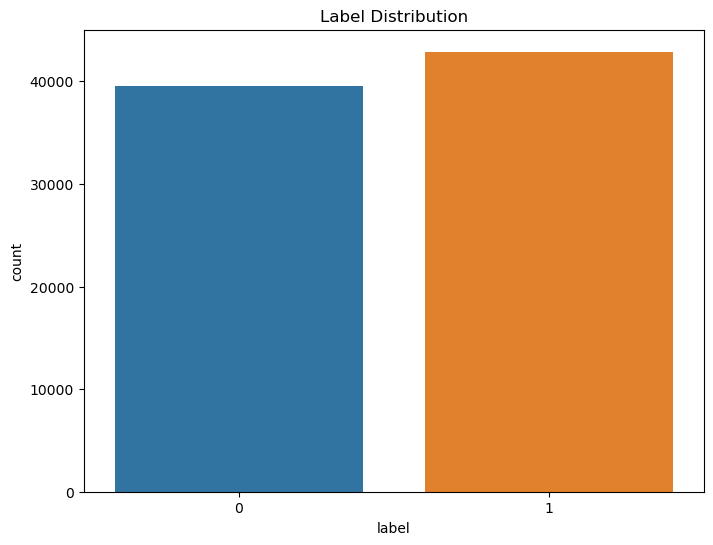

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

## Text length features

In [26]:
# Text Length Features
df['char_count'] = df['text_combined'].apply(len)
df['text_length'] = df['text_combined'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['text_combined'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
print(df['text_length'].describe())

count     82486.000000
mean        160.627222
std         543.720722
min           0.000000
25%          39.000000
50%          79.000000
75%         183.000000
max      107710.000000
Name: text_length, dtype: float64


## Text Length Distribution

In [13]:
filter = 1000 # 98% of the data is in these values

In [14]:
df[df['text_length'] > filter].shape

(1078, 5)

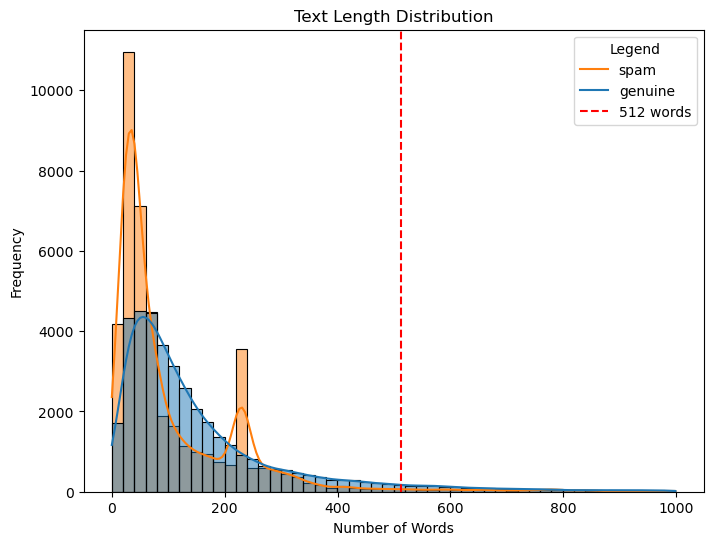

In [15]:
plt.figure(figsize=(8, 6))

sns.histplot(df[df['text_length'] < filter], x='text_length', hue='label', bins=50, kde=True)

# Add a vertical line at 512
plt.axvline(x=512, color='red', linestyle='--', label='Max Length Encoding (512)')

plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.legend(title='Legend',labels=['spam','genuine','512 words'])

plt.savefig('text_length_distribution.jpg', dpi=1000, bbox_inches='tight')

plt.show()

#### This plot is beneficial in order to see the length of the words that come from the spam/non spam. We can see that there is a difference between the density functions of the spam or not spam. They're both a long tail distribution. 
#### On the spam emails we can see that there are two peaks on the spam density function (possibly each generated by the same source, or for different spam pruposes). 
#### The genuine seems more like the classic long tail distribution we see in many fields (following the Power Law as we've seen in complex networks: https://www.sciencedirect.com/topics/medicine-and-dentistry/power-law)

# Word cloud - for the first few emails

#### Wordcloud is used in order to visualize the words that are in the emails. words that are more common will appear bigger. 
#### Due to it's heavy computational complexity we only show the first few emails, in which we can still learn from.

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Ensure that the dataset has the correct columns
# Columns: 'text_combined' (email content) and 'label' (0 for non-phishing, 1 for phishing)
assert 'text_combined' in df.columns and 'label' in df.columns, "Dataset must contain 'text_combined' and 'label' columns."


In [5]:
# Separate phishing and non-phishing emails
phishing_emails = df[df['label'] == 1]['text_combined']
non_phishing_emails = df[df['label'] == 0]['text_combined']

# Combine all phishing and non-phishing emails into single text for each category
phishing_text = ' '.join(phishing_emails[:10])
non_phishing_text = ' '.join(non_phishing_emails[:10])



In [9]:
# Generate word clouds without specifying a font path
wordcloud_phishing = WordCloud(width=800, height=400, background_color='white').generate(phishing_text)
wordcloud_non_phishing = WordCloud(width=800, height=400, background_color='white').generate(non_phishing_text)

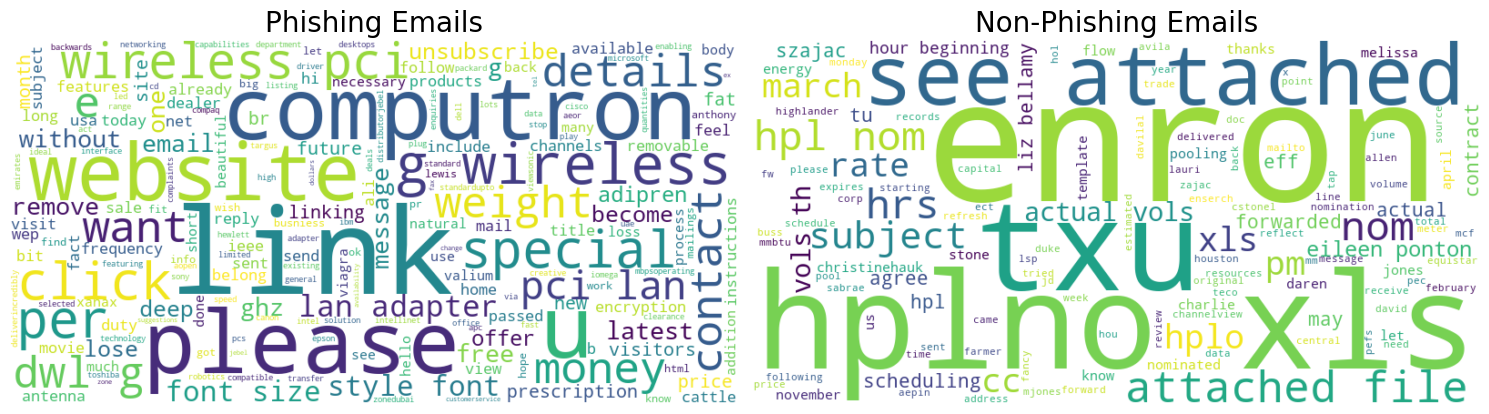

In [10]:
# Plotting the word clouds
plt.figure(figsize=(15, 8))

# Phishing emails word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_phishing, interpolation='bilinear')
plt.title('Phishing Emails', fontsize=20)
plt.axis('off')

# Non-Phishing emails word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_phishing, interpolation='bilinear')
plt.title('Non-Phishing Emails', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()


#### On the phishing email cloud we can see that there are some words that repeat that seem to us that would fit Phishing emails such as 'money', 'link', 'click'. The non-phishing seems a bit more noisy and harder to analyze, which makes sense becuase it could be emails on completely different subjecst that dont have a lot in common.

## Linguistic Features

#### Looking at Linguistic Features maybe we can anaylze and see differences in the different ways that people write emails, to distiguish if it's a phishing attempt or legitimate.

In [14]:
df['uppercase_count'] = df['text_combined'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['exclamation_count'] = df['text_combined'].apply(lambda x: x.count('!'))
df['question_count'] = df['text_combined'].apply(lambda x: x.count('?'))
df['special_char_count'] = df['text_combined'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Text analysis

#### We expected to see a lot of upper case letters an especially in the phishing E-mails.

In [16]:
def uppercase_proportion(text):
    total_chars = len(text)
    uppercase_chars = sum(1 for c in text if c.isupper())
    return uppercase_chars / total_chars if total_chars > 0 else 0

In [17]:
df['uppercase_proportion'] = df['text_combined'].apply(uppercase_proportion)

In [18]:
df[df['uppercase_proportion'] > 0]

,text_combined,label,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion
57883,john dlugosz dhcgnd702sneakemailcom tsa thomas...,0,4,0,0,0,0.003552
58229,xavier noria fxnhashrefcom thu aug 7 2008 319 ...,0,1,0,0,0,0.002198
81618,utf8bummrevdjkukgwqk yymkpcmircgryad95ofmcxjz6...,1,6,0,0,11,0.007500
81663,apple crendhyjembudorg 𝖯𝗈𝗅𝗂𝖼𝗒 𝖵𝗂𝗈𝗅𝖺𝗍𝗂𝗈𝗇 𝖨𝗆𝗆𝖾𝖽𝗂...,1,74,0,0,0,0.044444


### !

In [22]:
df[df['exclamation_count'] > 0]

,text_combined,label,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion


### ?

In [23]:
df[df['question_count'] > 0]

,text_combined,label,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion


#### We can see that there are no exclamation points and question marks in the data, possibly the data has been through some sort of pre-processing

### special

In [24]:
df[df['special_char_count'] > 0]

,text_combined,label,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion
44,gisb contracts intrastate interstate gas mr fa...,0,0,0,0,1,0.0
336,enron actuals july 14 thru 16 2000 revised ami...,0,0,0,0,2,0.0
429,revision 1 enron actuals may 11 2000 correct n...,0,0,0,0,2,0.0
433,revision 1 enron actuals may 18 2000 teco tap ...,0,0,0,0,2,0.0
577,unify gas month end close november 2001 please...,0,0,0,0,2,0.0
...,...,...,...,...,...,...,...
82478,netlflx cool390rnatlikadeliycom dear customer ...,1,0,0,0,2,0.0
82479,wetransfer no_replywetransfercom test transfer...,1,0,0,0,1,0.0
82481,info advantageapartmentscom infoadvantageapart...,1,0,0,0,34,0.0
82483,help center infohelpcentercoza_infohelpcenterc...,1,0,0,0,2,0.0


## Sentiment Analysisfrom

#### SentimentIntensityAnalyzer is a tool that measures the sentiment of text, providing scores for positive, negative, and neutral sentiment. 
#### For an email phishing detection task, it can help by analyzing the emotional tone of emails to identify suspicious patterns or language commonly used in phishing attempts, such as urgent or manipulative language.

In [29]:
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['text_combined'].apply(lambda x: sid.polarity_scores(x)['compound'])

## Readability Scores

#### Flesch-Kincaid Grade Level: Measures the U.S. school grade level needed to understand a text. A result of 8.0 means an eighth-grader should be able to understand it.

#### Flesch Reading Ease: Rates how easy a text is to read on a scale from 0 to 100. Higher scores mean easier readability (e.g., 90-100 is very easy, 0-30 is very difficult).

In [31]:
df['flesch_reading_ease'] = df['text_combined'].apply(flesch_reading_ease)
df['flesch_kincaid_grade'] = df['text_combined'].apply(flesch_kincaid_grade)

### Tokenize using nltk

#### nltk.word_tokenize is a function from the Natural Language Toolkit (NLTK) library used to split text into individual words or tokens. It handles punctuation and special characters, breaking down the text into a list of words and punctuation marks.

In [34]:
# Tokenize the text and remove stopwords
df['tokens'] = df['text_combined'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

In [35]:
df['token_length'] = df['tokens'].apply(lambda x: len(x))

In [36]:
df[df['token_length'] == df['text_length']].shape

(62343, 15)

## Calculate word frequency for phishing and non-phishing emails without converting to lowercase

#### The experiment showed that we should'nt convert as there is valuable information between converting and not converting that we hope the NLP model would detect. (possibly have an attention head that we would benefit from just like we saw in class)

In [37]:
# phishing_tokens = df[df['label'] == 1]['tokens'].sum()
# non_phishing_tokens = df[df['label'] == 0]['tokens'].sum()

# phishing_word_freq = Counter(phishing_tokens)
# non_phishing_word_freq = Counter(non_phishing_tokens)

In [ ]:
# # Display the most common words
# phishing_common_words = pd.DataFrame(phishing_word_freq.most_common(20), columns=['word', 'count'])
# non_phishing_common_words = pd.DataFrame(non_phishing_word_freq.most_common(20), columns=['word', 'count'])

##### Save the lists to file

In [ ]:
# phishing_common_words.to_csv('phishing_common_words.csv', index=False)
# non_phishing_common_words.to_csv('non_phishing_common_words.csv', index=False)

## Example of extracting TF-IDF features (Only 100 words because more than that is a heavy caclculation)

#### Using TF-IDF could potentially be beneficial but due to it's heavy computational complexity time, we decided just to show the added value on 100 features as when we model the NLP we won't be using it.

In [41]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['text_combined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

## List of spam-related words

#### We saw from the wordcloud analysis that there might be words that correlate with being spam so we tried to engineer a feature that would contain the "spam words". A quick analysis showed that the feature wasnt very successful, which shows how sophisticated the spam writers have become (trying to impersonate a legitimate purpose)

In [46]:
spam_words = ['free', 'win', 'winner', 'prize', 'cash', 'urgent', 'limited', 'act now', 'buy', 'cheap', 
              'discount', 'offer', 'credit', 'congratulations', 'risk-free', 'guarantee', 'save', 'order now', 
              'deal', 'click', 'subscribe', 'bonus']

# Add individual counts for each spam-related word
for word in spam_words:
    df[f'{word}_count'] = df['text_combined'].apply(lambda x: x.lower().split().count(word))

# Calculate correlation of each spam word count with the label
correlation = df[[f'{word}_count' for word in spam_words] + ['label']].corr()['label'].drop('label')

# Select words with positive correlation
positive_spam_words = correlation[correlation > 0].index

# Aggregate counts of positively correlated spam words
df['positive_spam_word_count'] = df[positive_spam_words].sum(axis=1)

In [47]:
# Print the correlation of spam words to the label
print(f'Words with positive correlation to label: {list(positive_spam_words)}')
print(df[['text_combined', 'label', 'positive_spam_word_count', 'sentiment']].head())

Words with positive correlation to label: ['free_count', 'win_count', 'winner_count', 'prize_count', 'cash_count', 'urgent_count', 'buy_count', 'cheap_count', 'discount_count', 'offer_count', 'congratulations_count', 'guarantee_count', 'save_count', 'click_count', 'bonus_count']
                                       text_combined  label  \
0  hpl nom may 25 2001 see attached file hplno 52...      0   
1  nom actual vols 24 th forwarded sabrae zajac h...      0   
2  enron actuals march 30 april 1 201 estimated a...      0   
3  hpl nom may 30 2001 see attached file hplno 53...      0   
4  hpl nom june 1 2001 see attached file hplno 60...      0   

   positive_spam_word_count  sentiment  
0                         0     0.0000  
1                         0     0.9313  
2                         0     0.0000  
3                         0     0.0000  
4                         0     0.0000  


In [52]:
#check how many columns are there:
spam_columns = [f'{word}_count' for word in spam_words]

non_zero_counts = {}

# Iterate over the columns and count non-zero values
for column in spam_columns:
    non_zero_counts[column] = (df[column] != 0).sum()

for column, count in non_zero_counts.items():
    print(f'{column}: {count} non-zero values')

free_count: 8483 non-zero values
win_count: 819 non-zero values
winner_count: 415 non-zero values
prize_count: 451 non-zero values
cash_count: 2211 non-zero values
urgent_count: 2024 non-zero values
limited_count: 3044 non-zero values
act now_count: 0 non-zero values
buy_count: 3417 non-zero values
cheap_count: 1324 non-zero values
discount_count: 703 non-zero values
offer_count: 5823 non-zero values
credit_count: 2498 non-zero values
congratulations_count: 613 non-zero values
risk-free_count: 0 non-zero values
guarantee_count: 1366 non-zero values
save_count: 4392 non-zero values
order now_count: 0 non-zero values
deal_count: 6002 non-zero values
click_count: 8206 non-zero values
subscribe_count: 960 non-zero values
bonus_count: 551 non-zero values


## Final reuslts df:

In [53]:
df

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion,...,congratulations_count,risk-free_count,guarantee_count,save_count,order now_count,deal_count,click_count,subscribe_count,bonus_count,positive_spam_word_count
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,4.153846,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,4.321429,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,6.294118,0,0,0,34,0.0,...,0,0,0,0,0,0,2,0,0,2
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,7.590909,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,7.787037,0,0,0,2,0.0,...,0,0,0,0,0,0,0,0,0,0
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,6.540000,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Split the data into train validation and test, and save to file

In [ ]:
# Initial split into train (70%) and test+eval (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the temp set into test (20%) and eval (10%)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=(1/3), random_state=42, stratify=y_temp)

# Combine features and target for train, test, and eval sets
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
eval = pd.concat([X_eval, y_eval], axis=1)

# Save to CSV
data_path = Path('path_to_data_directory')  # Replace with your actual data path
train.to_csv(Path(data_path, 'train_data.csv'), index=False)
test.to_csv(Path(data_path, 'test_data.csv'), index=False)
eval.to_csv(Path(data_path, 'eval_data.csv'), index=False)

# Save only text_combined and label columns to separate CSV files
train[["text_combined", "label"]].to_csv(Path(data_path, 'train_data_only_text_and_labels.csv'), index=False)
test[["text_combined", "label"]].to_csv(Path(data_path, 'test_data_only_text_and_labels.csv'), index=False)
eval[["text_combined", "label"]].to_csv(Path(data_path, 'eval_data_only_text_and_labels.csv'), index=False)